In [1]:
from keras.models import load_model
model = load_model("Donkey8.h5")

Using TensorFlow backend.


In [5]:
import cv2
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import deque
import math
from imutils.video import FPS
# initialize the camera and grab a reference to the raw camera capture

def binary_threshold(img, low, high):
    if len(img.shape) == 2:
        output = np.zeros_like(img)
        mask = (img >= low) & (img <= high)

    elif len(img.shape) == 3:
        output = np.zeros_like(img[:,:,0])
        mask = (img[:,:,0] >= low[0]) & (img[:,:,0] <= high[0]) \
            & (img[:,:,1] >= low[1]) & (img[:,:,1] <= high[1]) \
            & (img[:,:,2] >= low[2]) & (img[:,:,2] <= high[2])

    output[mask] = 1
    return output

def pipeline_threshold(img, visualise=False):

    ### LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    L = lab[:,:,0]
    L_max, L_mean = np.max(L), np.mean(L)
    B = lab[:,:,2]
    B_max, B_mean = np.max(B), np.mean(B)

    # YELLOW
    L_adapt_yellow = max(80, int(L_max * 0.45))
    B_adapt_yellow =  max(int(B_max * 0.70), int(B_mean * 1.2))
    lab_low_yellow = np.array((L_adapt_yellow, 120, B_adapt_yellow))
    lab_high_yellow = np.array((255, 145, 255))

    lab_yellow = binary_threshold(lab, lab_low_yellow, lab_high_yellow)
    lab_binary =lab_yellow

    ### HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    H = hsv[:,:,0]
    H_max, H_mean = np.max(H), np.mean(H)
    S = hsv[:,:,1]
    S_max, S_mean = np.max(S), np.mean(S)
    V = hsv[:,:,2]
    V_max, V_mean = np.max(V), np.mean(V)

    # YELLOW
    S_adapt_yellow =  max(int(S_max * 0.25), int(S_mean * 1.75))
    V_adapt_yellow =  max(50, int(V_mean * 1.25))
    hsv_low_yellow = np.array((15, S_adapt_yellow, V_adapt_yellow))

    hsv_high_yellow = np.array((30, 255, 255))
    hsv_yellow = binary_threshold(hsv, hsv_low_yellow, hsv_high_yellow)

    # WHITE
    V_adapt_white = max(150, int(V_max * 0.8),int(V_mean * 1.25))
    hsv_low_white = np.array((0, 0, V_adapt_white))
    hsv_high_white = np.array((255, 40, 220))

    hsv_white = binary_threshold(hsv, hsv_low_white, hsv_high_white)

    hsv_binary = hsv_yellow | hsv_white

    ### HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    L = hls[:,:,1]
    L_max, L_mean = np.max(L), np.mean(L)
    S = hls[:,:,2]
    S_max, S_mean = np.max(S), np.mean(S)

    # YELLOW
    L_adapt_yellow = max(80, int(L_mean * 1.25))
    S_adapt_yellow = max(int(S_max * 0.25), int(S_mean * 1.75))
    hls_low_yellow = np.array((15, L_adapt_yellow, S_adapt_yellow))
    hls_high_yellow = np.array((30, 255, 255))

    hls_yellow = binary_threshold(hls, hls_low_yellow, hls_high_yellow)

    # WHITE
    L_adapt_white =  max(160, int(L_max *0.8),int(L_mean * 1.25))
    hls_low_white = np.array((0, L_adapt_white,  0))
    hls_high_white = np.array((255, 255, 255))

    hls_white = binary_threshold(hls, hls_low_white, hls_high_white)

    hls_binary = hls_yellow | hls_white

    ### R color channel (WHITE)
    R = img[:,:,0]
    R_max, R_mean = np.max(R), np.mean(R)

    R_low_white = min(max(150, int(R_max * 0.55), int(R_mean * 1.95)),230)
    R_binary = binary_threshold(R, R_low_white, 255)

    adapt_yellow_S = cv2.adaptiveThreshold(hls[:,:,2], 1, \
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -5)
    adapt_yellow_B = cv2.adaptiveThreshold(lab[:,:,2], 1, \
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -5)
    adapt_yellow = adapt_yellow_S & adapt_yellow_B

    # WHITE
    adapt_white_R = cv2.adaptiveThreshold(img[:,:,0], 1, \
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -27)
    adapt_white_L = cv2.adaptiveThreshold(hsv[:,:,2], 1, \
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -27)
    adapt_white = adapt_white_R & adapt_white_L

    adapt_binary =  adapt_yellow | adapt_white


    combined = np.asarray(R_binary + lab_binary + hls_binary + hsv_binary + adapt_binary, dtype=np.uint8)

    combined[combined < 3] = 0
    combined[combined >= 3] = 1
    kernel_size = 15
    combined = cv2.GaussianBlur(combined, (kernel_size, kernel_size), 0)

    return  combined

def perspective_transform(img):
    h,w = img.shape[:2]
    rows, cols = img.shape[:2]


    #src = np.float32([[cols*0.01, rows*0.98],[cols*0.1, rows*0.08],
    #                  [cols*0.8, rows*0.08],[cols*0.99, rows*0.98]])
    src = np.float32([[cols*0.01, rows*0.98],[cols*0.05, rows*0.322],
                      [cols*0.70, rows*0.322],[cols*0.99, rows*0.99]])

    dst = np.float32([[0, img.shape[0]], [0, 0+0],
                      [450/2, 0+0], [639/2, img.shape[0]]])
    #dst = np.float32([[50, img.shape[0]], [50, 0],
    #                  [550, 0], [550, img.shape[0]]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv, src

def perspective_transform_helper(img):
    warped,_,_,_ = perspective_transform(img)
    return warped

Text(0.5, 1.0, 'Preprocessed Image')

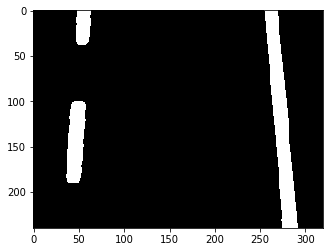

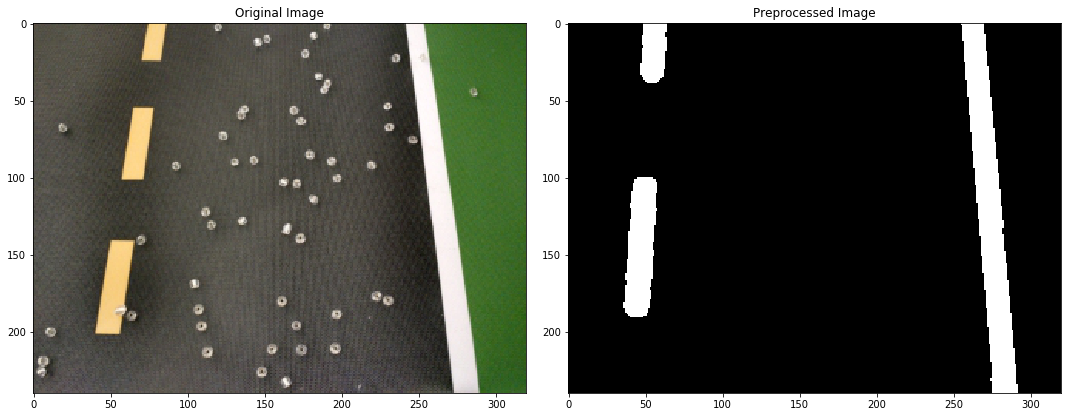

In [8]:
import os

img = mpimg.imread("snow2.jpg")
warped, _,_, _ = perspective_transform(pipeline_threshold(img))
plt.imshow(warped, cmap='gray')

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(img)
axs[0].set_title('Original Image')
axs[1].imshow(warped, cmap = 'gray')
axs[1].set_title('Preprocessed Image')

In [ ]:
def img_preprocess(img):
    #print(img.shape)
    #img = img[60:135,:,:]
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    #img = cv2.GaussianBlur(img,  (3, 3), 0)
    #img = cv2.resize(img, (200, 66))
    img, _,_, _ = perspective_transform(pipeline_threshold(img))
    #img = np.resize(img, (120, 160,1))
    #img = img/255
    
    return img

In [ ]:

original_image = mpimg.imread("Raspi_images/New/NewNew/NewNewNew/a (7).jpg")

dim = (160, 120)
#resized = cv2.resize(original_image, dim, interpolation = cv2.INTER_AREA)
#print(resized.shape)

#plt.imshow(resized)
img_processed = img_preprocess(original_image)
print(img_processed.shape)
resized = cv2.resize(img_processed, dim, interpolation = cv2.INTER_AREA)
print(resized.shape)
#plt.imshow(resized, 'gray')

resized = np.resize(resized, (1, 120, 160, 1))
print(resized.shape)

print(resized[0,:,:,0])
plt.imshow(resized[0,:,:,0], cmap='gray')
#cv2.imshow("prank", resized[0,:,:,0])
#cv2.waitKey(0)

In [ ]:
angle = (model.predict(resized))